# Linear Discriminant Analysis

Let $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n\in\mathbb{R}^m$ be observation with known class lables $z_1,\ldots,z_n$.
Then the aim of the Linear Discrimint Analysis (LDA) is to find a linear projection $\pi:\mathbb{R}^m\to\mathbb{R}^k$ so that individual classes are maximally separated.
What that exactly means will be discussed below.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import multivariate_normal
from numpy.linalg import norm

# Local imports
from common import *
from convenience import *

## I.  Spherical normal distributions

Consider the case where points with same label $j\in\{1,\ldots,\ell\}$ come from a multivariate normal distribution $\mathcal{N}(\boldsymbol{\mu}_j, \boldsymbol{\mathrm{I}})$. 
If we project the data downto one-dimensional subspace, we can get quite different results. Sometimes classes are perfectly mixed and sometimes classes are very distinct.  

In [7]:
# Dataset size
n = 1000

# Cluster parameters
Theta = (DataFrame({'x1': [-1.5, 1.5], 'x2': [0.0, 0.0], 
                    'lambda': [0.5, 0.5], 'z': ['A', 'B']})
         .set_index('z', drop=False))

# Dataset generation
df = (DataFrame(multivariate_normal(cov=np.identity(2)).rvs(n),columns=['x1', 'x2'])
      .assign(z = np.random.choice(Theta['z'], p=Theta['lambda'], size = n))
      .assign(x1 = lambda df:  df['x1'] + Theta.loc[df['z'], 'x1'].values)
      .assign(x2 = lambda df:  df['x2'] + Theta.loc[df['z'], 'x2'].values))

mdisplay([Theta,head(df)], ['Model parameters', 'Simulated data'])

Model parameters Simulated data 
 
 
 x1 
 x2 
 lambda 
 z 
 
 
 
 
 -1.5 
 0.0 
 0.5 
 A 
 
 
 1.5 
 0.0 
 0.5 
 B 
 
 
 
 
 
 x1 
 x2 
 z 
 
 
 
 
 -1.244621 
 -0.432526 
 A 
 
 
 0.380039 
 -0.243858 
 A 
 
 
 2.063823 
 0.112290 
 B 
 
 
 -1.006970 
 0.355420 
 A 
 
 
 -1.171159 
 0.439758 
 A

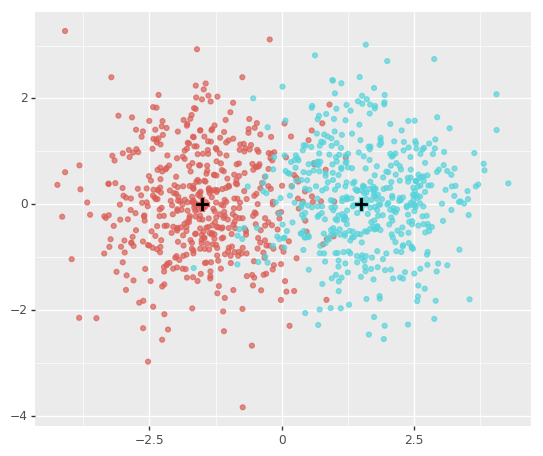

<ggplot: (-9223372029315209286)>

In [3]:
p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=False)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed()
p.save('simplified_lda_setup_i.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## II. Their projections to one-dimensional subspaces

Let us take four directions $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_4$ onto which we could project the data.
For any direction $\boldsymbol{w}$ the corresponding projections will be $y_i=\boldsymbol{w}^T\boldsymbol{x}_i$. 

### Unit vectors defining projections

,x1,x2
0,0.000000,1.000000
1,1.000000,0.000000
2,0.707107,0.707107
3,-0.949243,-0.314544


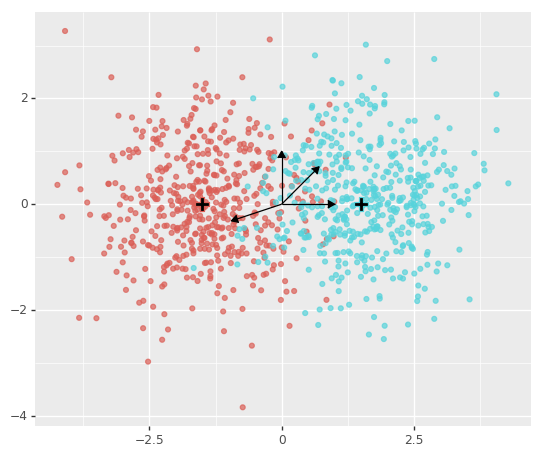

<ggplot: (-9223372029314829999)>

In [4]:
W = (DataFrame([(0,1), (1,0), (1,1), multivariate_normal(cov=np.identity(2)).rvs(1)], columns = ['x1', 'x2'])
     .assign(d  = lambda df: np.sqrt(df['x1']**2 + df['x2']**2))
     .assign(x1 = lambda df: df['x1']/df['d'])
     .assign(x2 = lambda df: df['x2']/df['d'])
     [['x1','x2']])
     
display(W)

p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=False)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed()
p = p + geom_segment(aes(xend = 'x1', yend='x2'), data = W, x=0, y=0, arrow=arrow(type = 'closed', length=0.1))
p.save('simplified_lda_setup_ii.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Corresponding projections and their visualisations

,z,p1,p2,p3,p4
0,A,-0.432526,-1.244621,-1.185922,1.317496
1,A,-0.243858,0.380039,0.096295,-0.284045
2,B,0.112290,2.063823,1.538744,-1.994389
3,A,0.355420,-1.006970,-0.460715,0.844064
4,A,0.439758,-1.171159,-0.517179,0.973391


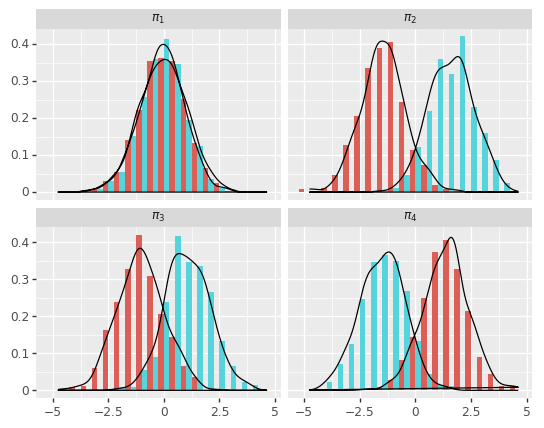

<ggplot: (-9223372029313670596)>

In [8]:
proj = (df[['z']]
      .assign(p1 = df[['x1', 'x2']].dot(W.loc[0, :]))
      .assign(p2 = df[['x1', 'x2']].dot(W.loc[1, :]))
      .assign(p3 = df[['x1', 'x2']].dot(W.loc[2, :]))
      .assign(p4 = df[['x1', 'x2']].dot(W.loc[3, :])))

display(head(proj))

tmp = (pd.melt(proj, id_vars=['z'], var_name='projector', value_name='y')
       .assign(projector =  lambda df: df['projector'].map(lambda x:'$\pi_{}$'.format(x[1]))))


p = ggplot(tmp)
p = p + geom_histogram(aes(x = 'y', y = '..density..', fill ='z'), binwidth=0.5, position='dodge')
p = p + stat_density(aes(x = 'y'), geom = "line", position = "identity", group = 'z') 
p = p + facet_wrap(['projector'])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + scale_fill_discrete(name='', guide=False)
p.save('simplified_lda_setup_iii.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## III. Optimal projection direction for one-dimensional subspace

As different directions lead to different separations, we can ask what is the most separating direction. 
For that we propose two hypotheses:

* The projected data $y_1,\ldots, y_n$ comes from a normal distribution $\mathcal{N}(\bar{y}, 1)$
* The projected data  $y_1,\ldots, y_n$ comes from a mixture of normal distributions $\mathcal{N}(\bar{y}_1,1),\ldots \mathcal{N}(\bar{y}_\ell,1)$.

As we know the cluster label for each datapoint we can compute

\begin{align*}
p[y_i|\mathcal{H}_0]&=\frac{1}{\sqrt{2\pi}}\cdot \exp\Bigl(-\frac{1}{2}(y_i-\bar{y})^2\Bigl)\\
p[y_i|\mathcal{H}_1]&=\frac{1}{\sqrt{2\pi}}\cdot \exp\Bigl(-\frac{1}{2}(y_i-\bar{y}_{z_i})^2\Bigl)
\end{align*}

from which we get

\begin{align*}
\log\frac{p[y_1,\ldots,y_n|\mathcal{H}_1]}{p[y_1,\ldots,y_n|\mathcal{H}_0]}= 
\frac{1}{2}\cdot\sum_{i=1}^n (y_i-\bar{y})^2
-\frac{1}{2}\cdot \sum_{i=1}^n (y_i-\bar{y}_{z_i})^2
\end{align*}

If we assign uniformative prior to both models then the Bayes factor

\begin{align*}
\frac{\Pr[\mathcal{H}_1|y_1,\ldots,y_n]}{\Pr[\mathcal{H}_0|y_1,\ldots,y_n]}= 
\frac{p[y_1,\ldots,y_n|\mathcal{H}_1]}{p[y_1,\ldots,y_n|\mathcal{H}_0]}
\end{align*}

show how many times the hypothesis $\mathcal{H}_1$ is more probable than $\mathcal{H}_0$.
Under our beliefs $\mathcal{H}_1$ is the correct model and thus it makes sense to consider the projection direction that maximises the Bayes factor, i.e., we need to solve

\begin{align*}
F=\sum_{i=1}^n (y_i-\bar{y})^2
-\sum_{i=1}^n (y_i-\bar{y}_{z_i})^2\to \max
\end{align*}

Note that maximum likelihood estimates for the cluster centers are

\begin{align*}
\bar{y}&=\frac{1}{n}\cdot\sum_{i=1}^n y_i\\
\bar{y}_j&=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j}^n y_j\\
\end{align*}

where $\mathcal{I}_j=\{i: z_i=j\}$. This allows us to express

\begin{align*}
\sum_{i=1}^n (y_i-\bar{y})^2&=\sum_{i=1}^n (y_i-\bar{y}_{z_i}+\bar{y}_{z_i}-\bar{y})^2\\
&=\sum_{i=1}^n (y_i-\bar{y}_{z_i})^2 +2\cdot \sum_{i=1}^n (y_i-\bar{y}_{z_i})(\bar{y}_{z_i}-\bar{y}_i)+\sum_{i=1}^n (\bar{y}_{z_i}-\bar{y})^2\\
&=\sum_{i=1}^n (y_i-\bar{y}_{z_i})^2 +\sum_{i=1}^n (\bar{y}_{z_i}-\bar{y})^2
\end{align*}

and thus the maximisation task becomes

\begin{align*}
F=\sum_{i=1}^n (\bar{y}_{z_i}-\bar{y})^2\to \max
\end{align*}

The latter can be further simplified to 

\begin{align*}
\sum_{j=1}^\ell \frac{|\mathcal{I}_j|}{n}(\bar{y}_{j}-\bar{y})^2\to \max
\end{align*}

For centered data $\bar{y}=0$ and we must maximize the weighted sum of cluster center distance squares.

### Direct computation and optimised computation of Bayes factors

In [30]:
ybar = pd.concat([DataFrame(proj.mean(), columns = ['*']).T, proj.groupby('z').mean()])
display(ybar)

,p1,p2,p3,p4
*,-0.054869,0.122486,0.047813,-0.099011
A,-0.007077,-1.446312,-1.027701,1.375128
B,-0.100239,1.611775,1.068817,-1.498436


Likelihood for the null hypothesis $\mathcal{H}_0$:

In [68]:
logpr_h0 = DataFrame(DataFrame({'p1': stats.norm(loc = ybar.loc['*', 'p1']).logpdf(proj['p1']),
                                'p2': stats.norm(loc = ybar.loc['*', 'p2']).logpdf(proj['p2']),
                                'p3': stats.norm(loc = ybar.loc['*', 'p3']).logpdf(proj['p3']),
                                'p4': stats.norm(loc = ybar.loc['*', 'p4']).logpdf(proj['p4'])
                               }).sum()).T

display(logpr_h0)

,p1,p2,p3,p4
0,-1446.214075,-2586.841546,-1994.682653,-2460.945115


Likelihood for the alternative hypothesis $\mathcal{H}_1$:

In [69]:
logpr_h1 = DataFrame({'p1': [stats.norm(loc = ybar.loc['A', 'p1']).logpdf(proj.loc[proj['z'] == 'A', 'p1']).sum() + 
                             stats.norm(loc = ybar.loc['B', 'p1']).logpdf(proj.loc[proj['z'] == 'B', 'p1']).sum()],
                      'p2': [stats.norm(loc = ybar.loc['A', 'p2']).logpdf(proj.loc[proj['z'] == 'A', 'p2']).sum() +
                             stats.norm(loc = ybar.loc['B', 'p2']).logpdf(proj.loc[proj['z'] == 'B', 'p2']).sum()],    
                      'p3': [stats.norm(loc = ybar.loc['A', 'p3']).logpdf(proj.loc[proj['z'] == 'A', 'p3']).sum() +
                             stats.norm(loc = ybar.loc['B', 'p3']).logpdf(proj.loc[proj['z'] == 'B', 'p3']).sum()],    
                      'p4': [stats.norm(loc = ybar.loc['A', 'p4']).logpdf(proj.loc[proj['z'] == 'A', 'p4']).sum() +
                             stats.norm(loc = ybar.loc['B', 'p4']).logpdf(proj.loc[proj['z'] == 'B', 'p4']).sum()]
                     })                
display(logpr_h1)

,p1,p2,p3,p4
0,-1445.129912,-1418.644743,-1445.630312,-1429.47186


Bayes factors to selected directions indicate that the best projection is $\pi_2$ and the worst projection is $\pi_1$ as expected.

In [72]:
display(logpr_h1-logpr_h0)

,p1,p2,p3,p4
0,1.084163,1168.196803,549.052341,1031.473254


Optimised computation of bayes factors leads to the same answer as expected

In [93]:
DataFrame(0.5*((ybar.loc[proj['z']] - ybar.loc['*'])**2).sum()).T

,p1,p2,p3,p4
0,1.084163,1168.196803,549.052341,1031.473254


## IV. Optimal projection direction for k-dimensional subspaces

Let $\pi:\mathbb{R}\to\mathbb{R}$ be orthoprojector specified by $m\times k$ matrix $\boldsymbol{\mathrm W}$, that is $\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm W}=\boldsymbol{\mathrm I}$. Then the projector converts spherical normal distribution into spherical normal distribution.
Indeed, let $\boldsymbol{y}=\boldsymbol{\mathrm W}^T\boldsymbol{x}$ be a random variable for $\boldsymbol{x}\sim\mathcal{N}(\boldsymbol{0},\boldsymbol{\mathrm{I}})$. Then we get the desired conformation

\begin{align*}
\boldsymbol{\mathrm{Cov}}[\boldsymbol{y}]=\boldsymbol{\mathrm{E}}[\boldsymbol{y}\boldsymbol{y}^T]=
\boldsymbol{\mathrm{E}}[\boldsymbol{\mathrm W}^T\boldsymbol{x}\boldsymbol{x}^T\boldsymbol{\mathrm W}]=
\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm{E}}[\boldsymbol{x}\boldsymbol{x}^T]\boldsymbol{\mathrm W}=
\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm W}=\boldsymbol{\mathrm{I}}\enspace.
\end{align*}

In brief, the orthoprojector can change only the centerpoint of the distribution. 
Hence, we can still propose two hypotheses:

* The projected data $\boldsymbol{y}_1,\ldots, \boldsymbol{y}_n$ comes from a normal distribution $\mathcal{N}(\bar{\smash{\boldsymbol{y}}}, \boldsymbol{\mathrm{I}})$
* The projected data  $\boldsymbol{y}_1,\ldots, \boldsymbol{y}_n$ comes from a mixture of normal distributions $\mathcal{N}(\bar{\smash{\boldsymbol{y}}}_1,\boldsymbol{\mathrm{I}}),\ldots \mathcal{N}(\bar{\smash{\boldsymbol{y}}}_\ell,\boldsymbol{\mathrm{I}})$.

As we know the cluster label for each datapoint we can compute

\begin{align*}
p[\boldsymbol{y}_i|\mathcal{H}_0]&=\frac{1}{(2\pi)^{k/2}}\cdot \exp\Bigl(-\frac{1}{2}\cdot(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})\Bigl)\\
p[\boldsymbol{y}_i|\mathcal{H}_1]&=\frac{1}{(2\pi)^{k/2}}\cdot \exp\Bigl(-\frac{1}{2}\cdot(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})\Bigl)
\end{align*}

from which we get

\begin{align*}
\log\frac{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_1]}{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_0]}= 
\frac{1}{2}\cdot\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})
-\frac{1}{2}\cdot \sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})
\end{align*}

If we assign uniformative prior to both models then the Bayes factor

\begin{align*}
\frac{\Pr[\mathcal{H}_1|\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n]}
{\Pr[\mathcal{H}_0|\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n]}= 
\frac{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_1]}
{p[\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n|\mathcal{H}_0]}
\end{align*}

show how many times the hypothesis $\mathcal{H}_1$ is more probable than the null hypothesis $\mathcal{H}_0$.
Under our beliefs $\mathcal{H}_1$ is the correct model and thus it makes sense to consider an orthoprojector that maximises the Bayes factor, i.e., we need to solve

\begin{align*}
\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})
-\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})\to \max
\end{align*}

Note that maximum likelihood estimates for the cluster centers are

\begin{align*}
\bar{\smash{\boldsymbol{y}}}&=\frac{1}{n}\cdot\sum_{i=1}^n \boldsymbol{y}_i\\
\bar{\smash{\boldsymbol{y}}}_j&=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j}^n \boldsymbol{y}_j\\
\end{align*}

where $\mathcal{I}_j=\{i: z_i=j\}$. This allows us to express

\begin{align*}
\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})^T(\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}})
&=\sum_{i=1}^n (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})^T (\boldsymbol{y}_i-\bar{\smash{\boldsymbol{y}}}_{z_i})
+\sum_{i=1}^n (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})^T (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})
\end{align*}

and thus the maximisation task becomes

\begin{align*}
F=\sum_{i=1}^n (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})^T (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})\to \max
\end{align*}

For centered data we are looking a projector that maximises the weighted distance squares of the clusters.

### Example

??

## V. Closed form solution for the optimisation task

Recall that our goal is to find ortoprojector defined by $\boldsymbol{\mathrm{W}}$ such that

\begin{align*}
F=\sum_{i=1}^n (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})^T (\bar{\smash{\boldsymbol{y}}}_{z_i}-\bar{\smash{\boldsymbol{y}}})\to \max
\end{align*}

Let 

\begin{align*}
\boldsymbol{\mu}&=\frac{1}{n}\cdot\sum_{i=1}^n \boldsymbol{x}_i
\end{align*}

denote the center point for the entire data and

\begin{align*}
\boldsymbol{\mu}_j&=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j}^n \boldsymbol{x}_j\\
\end{align*}

center points for the clusters. 
Then due to linearity $\bar{\smash{\boldsymbol{y}}}=\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu}$ and 
$\bar{\smash{\boldsymbol{y}}}_j=\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu}_j$ and we can rewrite the quantity to be maximised in a different form

\begin{align*}
F&=\sum_{i=1}^n (\boldsymbol{\mathrm{W}}^T\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu})^T (\boldsymbol{\mathrm{W}}^T\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{W}}^T \boldsymbol{\mu})\\
&=\sum_{i=1}^n (\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T \boldsymbol{\mathrm{W}}\boldsymbol{\mathrm{W}}^T (\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})\\
&= \sum_{i=1}^n \sum_{j=1}^k(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T \boldsymbol{w}_j\boldsymbol{w}_j^T (\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})\\
&= \sum_{i=1}^n \sum_{j=1}^k \boldsymbol{w}_j^T(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T\boldsymbol{w}_j\\
&=  \sum_{j=1}^k \boldsymbol{w}_j^T\Bigl( \sum_{i=1}^n(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T\Bigr)\boldsymbol{w}_j
\end{align*}

Now let 
\begin{align*}
\boldsymbol{\mathrm{S}}_B=\sum_{i=1}^n(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T 
\end{align*}

be the between cluster scatter matrix. Then we can recast the maximisation task 

\begin{align*}
\sum_{j=1}^k \boldsymbol{w}_j^T\boldsymbol{\mathrm S}_B\boldsymbol{w}_j \to \max
\end{align*}
where $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_k$ are orthogonal vectors. 
As the skatter matrix is positively definite there exist orthogonal basis of eigenvectors $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_m$ with corresponding eigenvalues $\lambda_1\geq \ldots\geq\lambda_m$. 
The sum is maximised only if we take first $k$ eigenvectors.




### Three-dimensional example continued

## VI. Normal distributions with arbitrary shape

Consider the case where points with same label $j\in\{1,\ldots,\ell\}$ come from a multivariate normal distribution $\mathcal{N}(\boldsymbol{\mu}_j, \boldsymbol{\Sigma})$, i.e., all clusters share the covariance matrix $\boldsymbol{\Sigma}$. 
Again, if we project the data downto one-dimensional subspace, we can get quite different results. Sometimes classes are perfectly mixed and sometimes classes are very distinct.  

Model parameters Simulated data 
 
 
 x1 
 x2 
 lambda 
 z 
 
 
 
 
 -1.5 
 0.0 
 0.5 
 A 
 
 
 1.5 
 0.0 
 0.5 
 B 
 
 
 
 
 
 x1 
 x2 
 z 
 
 
 
 
 -2.522609 
 -0.722506 
 A 
 
 
 2.135184 
 1.012353 
 B 
 
 
 1.668769 
 -0.121846 
 B 
 
 
 1.210813 
 -1.508365 
 B 
 
 
 -2.565105 
 0.539563 
 A

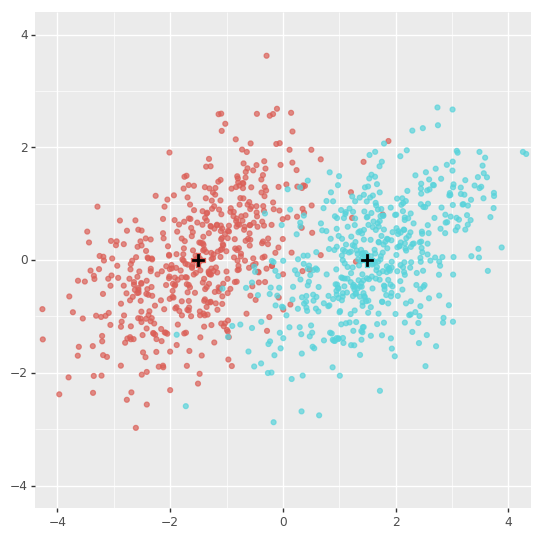

<ggplot: (-9223372029311020449)>

In [204]:
# Dataset size
n = 1000

Sigma = np.array([[1.0, 0.5], [0.5, 1.0]])

# Cluster parameters
Theta = (DataFrame({'x1': [-1.5, 1.5], 'x2': [0.0, 0.0], 
                    'lambda': [0.5, 0.5], 'z': ['A', 'B']})
         .set_index('z', drop=False))

# Dataset generation
df = (DataFrame(multivariate_normal(cov=Sigma).rvs(n),columns=['x1', 'x2'])
      .assign(z = np.random.choice(Theta['z'], p=Theta['lambda'], size = n))
      .assign(x1 = lambda df:  df['x1'] + Theta.loc[df['z'], 'x1'].values)
      .assign(x2 = lambda df:  df['x2'] + Theta.loc[df['z'], 'x2'].values))

mdisplay([Theta,head(df)], ['Model parameters', 'Simulated data'])

p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=False)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed(xlim=(-4,4), ylim=(-4,4))
p.save('general_lda_setup_i.pdf', path='results', height=6, width=6, verbose=False)
display(p)

## VII. Their projections to one-dimensional subspaces

Let us take four directions $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_4$ onto which we could project the data.
For any direction $\boldsymbol{w}$ the corresponding projections will be $y_i=\boldsymbol{w}^T\boldsymbol{x}_i$. 

### Unit vectors defining projections

,x1,x2
0,0.000000,1.000000
1,1.000000,0.000000
2,-0.707107,0.707107
3,-0.552722,0.833365


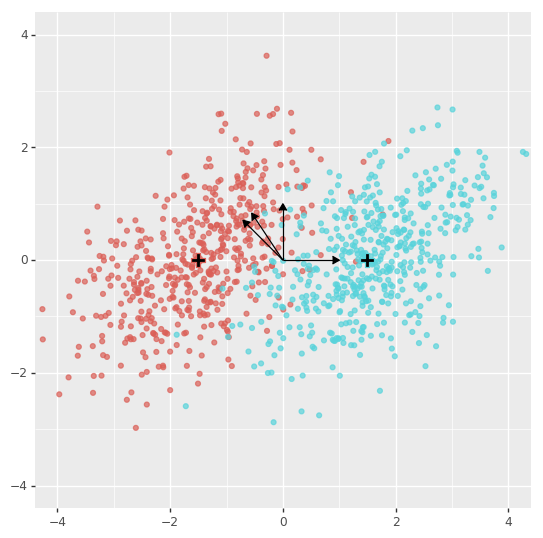

<ggplot: (-9223372029309786652)>

In [210]:
W = (DataFrame([(0,1), (1,0), (-1,1), multivariate_normal(cov=np.identity(2)).rvs(1)], columns = ['x1', 'x2'])
     .assign(d  = lambda df: np.sqrt(df['x1']**2 + df['x2']**2))
     .assign(x1 = lambda df: df['x1']/df['d'])
     .assign(x2 = lambda df: df['x2']/df['d'])
     [['x1','x2']])
     
display(W)

p = ggplot(df)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'x1', y = 'x2', color = 'z'), data = Theta, shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=False)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed(xlim=(-4,4), ylim=(-4,4))
p = p + geom_segment(aes(xend = 'x1', yend='x2'), data = W, x=0, y=0, arrow=arrow(type = 'closed', length=0.1))
p.save('general_lda_setup_ii.pdf', path='results', height=6, width=6, verbose=False)
display(p)

### Corresponding projections and their visualisations

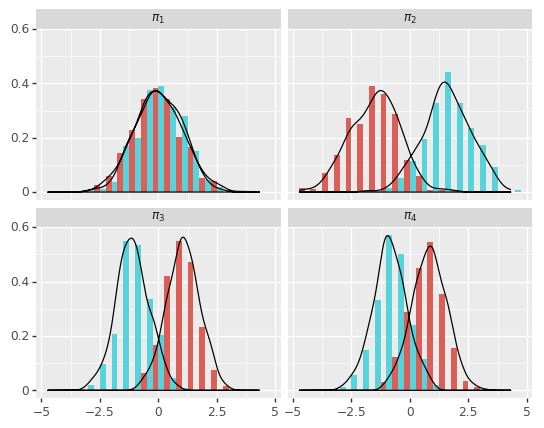

<ggplot: (7541258893)>

In [211]:
proj = (df[['z']]
      .assign(p1 = df[['x1', 'x2']].dot(W.loc[0, :]))
      .assign(p2 = df[['x1', 'x2']].dot(W.loc[1, :]))
      .assign(p3 = df[['x1', 'x2']].dot(W.loc[2, :]))
      .assign(p4 = df[['x1', 'x2']].dot(W.loc[3, :])))
head(proj)

tmp = (pd.melt(proj, id_vars=['z'], var_name='projector', value_name='y')
       .assign(projector =  lambda df: df['projector'].map(lambda x:'$\pi_{}$'.format(x[1]))))


p = ggplot(tmp)
p = p + geom_histogram(aes(x = 'y', y = '..density..', fill ='z'), binwidth=0.5, position='dodge')
p = p + stat_density(aes(x = 'y'), geom = "line", position = "identity", group = 'z') 
p = p + facet_wrap(['projector'])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + scale_fill_discrete(name='', guide=False)
p.save('general_lda_setup_iii.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## VIII. Data whitening transformation

As we know the cluster labels we can compute maximum likelihood estimate for cluster centers

\begin{align*}
\boldsymbol{\mu}_j=\frac{1}{|\mathcal{I}_j|}\cdot\sum_{i\in\mathcal{I}_j} \boldsymbol{x}_j
\end{align*}

and covariance matrix shared among clusters we can compute maximum likelihood estimate for the shared covariance aka whitin-class covariance

\begin{align*}
\boldsymbol{\Sigma}_W=\frac{1}{n}\cdot\sum_{i=1}^n (\boldsymbol{x}_i-\boldsymbol{\mu}_{z_i})(\boldsymbol{x}_i-\boldsymbol{\mu}_{z_i})^T
\end{align*}

Let the columns of $\boldsymbol{\mathrm W}$ be the orthonormal eigenvectors of $\boldsymbol{\Sigma}_W$:

\begin{align*}
\boldsymbol{\Sigma}_W \boldsymbol{\mathrm W} &= \mathrm{diag}(\boldsymbol{\lambda}) \boldsymbol{\mathrm W}\\
\boldsymbol{\mathrm W}^T\boldsymbol{\mathrm W} &= \boldsymbol{\mathrm I}
\end{align*}

Then we can define an invertible matrix 

\begin{align*}
\boldsymbol{\mathrm{A}} =  \mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)\boldsymbol{\mathrm{W}}^T 
\end{align*}

such that


\begin{align*}
\boldsymbol{\mathrm{A}}\boldsymbol{\Sigma}_w\boldsymbol{\mathrm{A}}^T=
\mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)\boldsymbol{\mathrm{W}}^T 
\boldsymbol{\Sigma}_w 
\boldsymbol{\mathrm{W}} \mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)=
\mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)
\mathrm{diag}\bigl(\boldsymbol{\lambda}\bigl)
\mathrm{diag}\bigl(\boldsymbol{\lambda}^{-1/2}\bigr)=
\boldsymbol{\mathrm{I}}\enspace.
\end{align*}

As a result if we define a transformation

\begin{align*}
\boldsymbol{x}_1^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_n
\end{align*}

then the maximum likelihood estimate for the covariance matrix for $\boldsymbol{x}_1^*,\ldots,\boldsymbol{x}_n^*$ is identity matrix $\boldsymbol{\mathrm I}$ and we are back in the setting with spherical normal distributions.  

### Inverse square root of a symmetric matrix

In [212]:
def matrix_invsqrt(Sigma: np.array) -> np.array:
    """
    Finds inverse square root of a matrix: A^T * A = Sigma^(-1)
    """

    assert all(Sigma == Sigma.T), 'Matrix must be symmetric'
        
    Lambda, W = np.linalg.eigh(Sigma)
    return np.dot(np.diag(Lambda**(-0.5)), W.T)        

### Whitening transformation

In [213]:
# Group extraction
XA = df.loc[df['z'] == 'A', ['x1', 'x2']]
XB = df.loc[df['z'] == 'B', ['x1', 'x2']]

# Data centering
XA = XA.transform(lambda x: x - np.mean(x))
XB = XB.transform(lambda x: x - np.mean(x))

# Covariance computation
Sigma_W = (XA.T.dot(XA) + XB.T.dot(XB))/len(df)
A = DataFrame(matrix_invsqrt(Sigma_W), columns = ['x1', 'x2'], index = ['xx1', 'xx2'])

# Data transformation
sdf = A.dot(df[['x1','x2']].T).T.assign(z = df['z'])

# Transformation of directions
Wx = A.dot(W.T).T

mdisplay([Sigma_W, A, head(sdf), Wx], ['Covariance matrix $\Sigma_W$', 'Scaling matrix', 'Result', 'Directions'])

Covariance matrix $\Sigma_W$ Scaling matrix Result Directions 
 
 
 x1 
 x2 
 
 
 
 
 1.074929 
 0.554757 
 
 
 0.554757 
 1.023620 
 
 
 
 
 
 x1 
 x2 
 
 
 
 
 0.982617 
 -1.029108 
 
 
 -0.570959 
 -0.545165 
 
 
 
 
 
 xx1 
 xx2 
 z 
 
 
 
 
 -1.735221 
 1.834191 
 A 
 
 
 1.056247 
 -1.771002 
 B 
 
 
 1.765154 
 -0.886372 
 B 
 
 
 2.742036 
 0.130984 
 B 
 
 
 -3.075784 
 1.170418 
 A 
 
 
 
 
 
 xx1 
 xx2 
 
 
 
 
 -1.029108 
 -0.545165 
 
 
 0.982617 
 -0.570959 
 
 
 -1.422504 
 0.018239 
 
 
 -1.400737 
 -0.138740

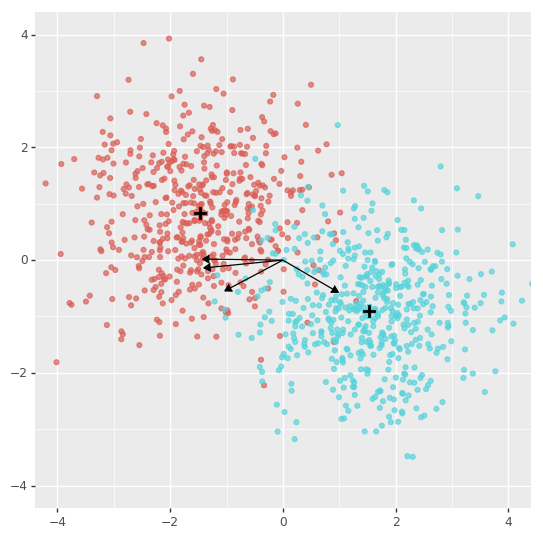

<ggplot: (-9223372029315050920)>

In [215]:
p = ggplot(sdf)
p = p + geom_point(aes(x = 'xx1', y = 'xx2', color = 'z'), alpha = 0.7)
p = p + geom_point(aes(x = 'xx1', y = 'xx2', color = 'z'), data = sdf.groupby('z').mean().reset_index(), shape = 'P', fill='black', size=5, )
p = p + scale_color_discrete(name='', guide=False)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + coord_fixed(xlim=(-4,4), ylim=(-4,4))
p = p + geom_segment(aes(xend = 'xx1', yend='xx2'), data = Wx, x=0, y=0, arrow=arrow(type = 'closed', length=0.1))
p.save('general_lda_setup_iv.pdf', path='results', height=6, width=6, verbose=False)
display(p)

## IX. Closed form solution for the maximisation task


As $\boldsymbol{x}_1^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n^*=\boldsymbol{\mathrm{A}}\boldsymbol{x}_n$ are having spherical normal distribution we can solve the maximisation task using between class scatter matrix $\boldsymbol{\mathrm S}_B^*$.
However, the matrix must be computed in terms of transformed datapoints $\boldsymbol{x}_1^*,\ldots,\boldsymbol{x}_n^*$ and their means $\boldsymbol{\mu}^*,\boldsymbol{\mu}_1^*,\ldots,\boldsymbol{\mu}_\ell^*$: 

\begin{align*}
\boldsymbol{\mathrm{S}}_B^*
&=\sum_{i=1}^n(\boldsymbol{\mu}_{z_i}^*-\boldsymbol{\mu}^*)
(\boldsymbol{\mu}_{z_i}^*-\boldsymbol{\mu}^*)^T \\
&=\sum_{i=1}^n(\boldsymbol{\mathrm{A}}\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{A}}\boldsymbol{\mu})
(\boldsymbol{\mathrm{A}}\boldsymbol{\mu}_{z_i}-\boldsymbol{\mathrm{A}}\boldsymbol{\mu})^T \\
&=\boldsymbol{\mathrm{A}}\Biggl(\sum_{i=1}^n(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})
(\boldsymbol{\mu}_{z_i}-\boldsymbol{\mu})^T\Biggr)\boldsymbol{\mathrm{A}}^T\\
&=
\boldsymbol{\mathrm{A}}S_B\boldsymbol{\mathrm{A}}^T
\end{align*}

After that we can solve the maximisation task in the transformed space

\begin{align*}
\sum_{j=1}^k {\boldsymbol{w}_j^*}^T\boldsymbol{\mathrm S}_B^*\boldsymbol{w}_j^* \to \max\\
\text{s.t. }{\boldsymbol{w}_i^*}^T\boldsymbol{w}_j^*=\delta_{i,j}
\end{align*}

by finding the eigenvectors $\boldsymbol{w}_1,\ldots,\boldsymbol{w}_m$ of $\boldsymbol{\mathrm S}_B^*$ with corresponding eigenvalues $\lambda_1\geq \ldots\geq\lambda_m$. 
The sum is maximised only if we take first $k$ eigenvectors.

# Homework 

## 4.1 Implement LDA algorithm (<font color='red'>2p</font>)

Implement LDA algorithm as a function for three-dimensional case. First, implement the algorithm for the spherica normal distribution and test it with cluster centres placed on symmetrical positions on the $xy$-plane:

\begin{align*}
\boldsymbol{\mu}_1&=(1,0,0)\\
\boldsymbol{\mu}_2&=(\sin(\pi/3),\cos(\pi/3),0)\\
\boldsymbol{\mu}_2&=(\sin(\pi/3),-\cos(\pi/3),0)\\
\end{align*}

and the shared covariance matrix $\boldsymbol{\mathrm I}$. Compute the amount of variance covered by LDA components that is the plane fixed by $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$. For the example above, LDA projection select $xy$-plane and you must compute the summary variance of the first two coordinates.

Second, implement the whitening transformation and compute the solution for the transformed data $\boldsymbol{w}_1^*$ and $\boldsymbol{w}_2^*$. After that translate this back to the original space, i.e., compute $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$. Again, compute the amount of variance covered by LDA components that is the plane fixed by $\boldsymbol{w}_1$ and $\boldsymbol{w}_2$ and compare with the entrire variance of the data. To test the function use any non-trivial affine transformation to map the test configuration specified above into non-spherical test configuration.  